# MadMiner particle physics tutorial

# Part C1: Likelihood Module: no systematics

Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer 2018-2019

In this notebook, we use the Likelihood class for a process without any systematics. 

## 0. Preparations

In [1]:
import sys
import os
madminer_src_path = "/Users/felixkling/Documents/GitHub/madminer"
sys.path.append(madminer_src_path)

from __future__ import absolute_import, division, print_function, unicode_literals

import logging
import numpy as np
import time
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

# MadMiner output
logging.basicConfig(
    format='%(asctime)-5.5s %(name)-20.20s %(levelname)-7.7s %(message)s',
    datefmt='%H:%M',
    level=logging.INFO
)

# Output of all other modules (e.g. matplotlib)
for key in logging.Logger.manager.loggerDict:
    if "madminer" not in key:
        logging.getLogger(key).setLevel(logging.WARNING)

from madminer.likelihood import NeuralLikelihood, HistoLikelihood, project_log_likelihood, profile_log_likelihood
from madminer.limits import AsymptoticLimits
from madminer.plotting import plot_pvalue_limits

20:54 madminer             INFO    
20:54 madminer             INFO    ------------------------------------------------------------------------
20:54 madminer             INFO    |                                                                      |
20:54 madminer             INFO    |  MadMiner v0.6.3                                                     |
20:54 madminer             INFO    |                                                                      |
20:54 madminer             INFO    |         Johann Brehmer, Felix Kling, Irina Espejo, and Kyle Cranmer  |
20:54 madminer             INFO    |                                                                      |
20:54 madminer             INFO    ------------------------------------------------------------------------
20:54 madminer             INFO    


We define the grid and luminosity 

In [2]:
grid_ranges = [(-1, 1.), (-1, 1.)]
grid_resolutions = [10, 10]

In [3]:
lumi = 300.*1000. 
n_asimov=1000
n_histo_toys=5000

In [4]:
p_values = {}
mle = {}
durations = {}

from madminer.likelihood import BaseLikelihood
from madminer.sampling import SampleAugmenter
from madminer.utils.various import math_commands, mdot, less_logging
from madminer import sampling
from madminer.utils.histo import Histo
from madminer.ml import Ensemble, ScoreEstimator, load_estimator
import time

logger = logging.getLogger(__name__)
class HistoLikelihood(BaseLikelihood):
    
    def create_negative_log_likelihood(
        self,
        x_observed,
        observables=None,
        score_components=None,
        n_observed=None,
        x_observed_weights=None,
        include_xsec=True,
        luminosity=300000.0,
        mode="sampled",
        n_histo_toys = 100000,
        model_file=None,
        hist_bins=None,
        n_histo_toys_binning = None,
        thetas_binning=None,
    ):
        """
        Returns a function which calculates the negative log likelihood for a given
        parameter point, evaulated with a dataset (x_observed,n_observed,x_observed_weights).

        Parameters
        ----------
        
        x_observed : list of ndarray
            Set of event observables with shape `(n_events, n_observables)`.
            
        observables : list of str or None , optional
            Kinematic variables used in the histograms. The names are the same as
            used for instance in `DelphesReader`.
            
        score_components : None or list of int, optional
            Defines the score components used. Default value: None.
        
        n_observed : int or None , optional
            If int, number of observed events. If None, n_observed is defined by 
            the length of x_observed. Default: None.
    
        x_observed_weights : list of float or None , optional
            List of event weights with shape `(n_events)`. If None, all events have equal 
            weights. Default: None.
        
        include_xsec : bool, optional
            Whether the Poisson likelihood representing the total number of events is
            included in the analysis. Default value: True.
        
        luminosity : float, optional
            Integrated luminosity in pb^{-1} assumed in the analysis. Default value: 300000.
            
        mode : {"rate" , "sampled"} , optional
            If "rate", only the likelihood in the rate is calculated.
            If "sampled", for each evaulation of the likelihood function, a separate
            set of events are sampled and histogram is created to construct the
            likelihood function. Default value: "sampled"
            
        n_histo_toys : int or None, optional
            Number of events drawn to construct the histograms used. If None and weighted_histo
            is True, all events in the training fraction of the MadMiner file are used. If None
            and weighted_histo is False, 100000 events are used. Default value: 100000.
            
        model_file : str or None, optional
            Filename of a saved neural network estimating the score. Required if
            score_components is not None. Default value: None.
            
        hist_bins : int or list of (int or ndarray) or None, optional
            Defines the histogram binning. If int, gives the number of bins automatically
            chosen for each summary statistic. If list, each entry corresponds to one
            summary statistic (e.g. kinematic variable specified by hist_vars); an int
            entry corresponds to the number of automatically chosen bins, an ndarray specifies
            the bin edges along this dimension explicitly. If None, the bins are chosen according
            to the defaults: for one summary statistic the default is 25 bins, for 2 it's 8 bins
            along each direction, for more it's 5 per dimension. Default value: None.
 
        n_histo_toys_binning : int or None, optional
            Number of toy events used to determine the binning of adaptive histograms.
            If None, ise same number as n_histo_toys. Default value: None.
            
        thetas_binning : list of ndarray or None
            Specifies the parameter points used to determine the optimal binning.
            This is requires if hist_bins doesn't already fully specify the 
            binning of the histogram. Default value : None
            
        Returns
        -------
        negative_log_likelihood : likelihood
            Function that evaluates the negative log likelihood for a given parameter point
            
        """
        
        #check input/load model
        if score_components is not None:
            assert all([isinstance(score_component,int) for score_component in score_components]) 
            if model_file is None:
                raise ValueError("You need to provide a model_file!")
            model = load_estimator(model_file)
        else:
            model = None
            
        if n_observed is None:
            n_observed = len(x_observed)
            
        if n_histo_toys_binning is None:
            n_histo_toys_binning=n_histo_toys
           
        #join observables and score components
        if observables is None and score_components is None: 
            mode="rate"
            include_xsec=True
        elif observables is None:
            observables=list(score_components)
        elif score_components is None:
            observables=list(observables)
        else: 
            observables=list(observables)+list(score_components)
            
        supported_modes=["sampled","rate"]
        if mode not in supported_modes:
            raise ValueError("Mode %s unknown. Choose one of the following methods: %s",mode, supported_modes)
        
        # find binning
        if not mode=="rate" and (hist_bins is None or not all([hasattr(hist_bin, "__len__") for hist_bin in hist_bins])):
            if thetas_binning is None:
                raise ValueError("Your input requires adaptive binning: thetas_binning can not be None.")
            hist_bins=self._find_bins(hist_bins=hist_bins,observables=observables)
            hist_bins=self._fixed_adaptive_binning(
                n_toys=n_histo_toys_binning, 
                observables=observables,
                thetas_binning=thetas_binning, 
                x_bins=hist_bins,
                model=model,
            )
            logger.info("Use binning: %s",hist_bins)
   
        #define negative likelihood function
        def nll(params):
            #Just return the expected Length
            if params is None:
                return self.n_nuisance_parameters+self.n_parameters
        
            #Process input
            if (len(params)!= self.n_nuisance_parameters+ self.n_parameters):
                logger.warning("Number of parameters is %s, expected %s physical parameters and %s nuisance paramaters",
                    len(params),self.n_parameters,self.n_nuisance_parameters )
            theta = params[: self.n_parameters]
            nu = params[self.n_parameters :]
            if len(nu)==0: nu=None
        
            #Compute Log Likelihood
            log_likelihood = self._log_likelihood(
                observables=observables, 
                n_events=n_observed, 
                xs=x_observed, 
                theta=theta, 
                nu=nu, 
                include_xsec=include_xsec, 
                luminosity=luminosity, 
                x_weights=x_observed_weights,
                mode=mode,
                n_histo_toys=n_histo_toys,
                hist_bins=hist_bins,
                model=model,
            )
            return -log_likelihood

        return nll

    def create_expected_negative_log_likelihood(
        self, 
        theta_true, 
        nu_true, 
        observables=None, 
        score_components=None,
        include_xsec=True, 
        luminosity=300000.0, 
        n_asimov=None,
        mode="sampled",
        n_histo_toys = 100000,
        model_file=None,
        hist_bins=None,
        n_histo_toys_binning = None,
        thetas_binning=None,
    ):
        """
        Returns a function which calculates the expected negative log likelihood for a given
        parameter point, evaulated with test data sampled according to theta_true.

        Parameters
        ----------
        theta_true : ndarray
            Specifies the physical paramaters according to which the test data is sampled. 
            
        nu_true : ndarray
            Specifies the nuisance paramaters according to which the test data is sampled. 
            
        observables : list of str or None , optional
            Kinematic variables used in the histograms. The names are the same as
            used for instance in `DelphesReader`.
            
        score_components : None or list of int, optional
            Defines the score components used. Default value: None.
        
        include_xsec : bool, optional
            Whether the Poisson likelihood representing the total number of events is
            included in the analysis. Default value: True.
        
        luminosity : float, optional
            Integrated luminosity in pb^{-1} assumed in the analysis. Default value: 300000.
            
        n_asimov : int or None, optional
            Size of the Asimov sample. If None, all weighted events in the MadMiner 
            file are used. Default value: None.
            
        mode : {"rate" , "sampled"}
            If "rate", only the likelihood in the rate is calculated.
            If "sampled", for each evaulation of the likelihood function, a separate
            set of events are sampled and histogram is created to construct the
            likelihood function.
            
        n_histo_toys : int or None, optional
            Number of events drawn to construct the histograms used. If None and weighted_histo
            is True, all events in the training fraction of the MadMiner file are used. If None
            and weighted_histo is False, 100000 events are used. Default value: 100000.
            
        model_file : str or None, optional
            Filename of a saved neural network estimating the score. Required if
            score_components is not None. Default value: None.
            
        hist_bins : int or list of (int or ndarray) or None, optional
            Defines the histogram binning. If int, gives the number of bins automatically
            chosen for each summary statistic. If list, each entry corresponds to one
            summary statistic (e.g. kinematic variable specified by hist_vars); an int
            entry corresponds to the number of automatically chosen bins, an ndarray specifies
            the bin edges along this dimension explicitly. If None, the bins are chosen according
            to the defaults: for one summary statistic the default is 25 bins, for 2 it's 8 bins
            along each direction, for more it's 5 per dimension. Default value: None.
          
        n_histo_toys_binning : int or None, optional
            Number of toy events used to determine the binning of adaptive histograms.
            If None, ise same number as n_histo_toys. Default value: None.
            
        thetas_binning : list of ndarray or None
            Specifies the parameter points used to determine the optimal binning.
            If none, theta_true will be used. Default value : None
            
        Returns
        -------
        negative_log_likelihood : likelihood
            Function that evaluates the negative log likelihood for a given parameter point
            
        """
        
        if thetas_binning is None:
            thetas_binning=[theta_true]
        
        x_asimov, x_weights = self._asimov_data(theta_true, n_asimov=n_asimov)
        n_observed = luminosity * self.xsecs([theta_true], [nu_true])[0]

        return self.create_negative_log_likelihood(
            observables=observables,
            score_components=score_components,
            x_observed=x_asimov,
            n_observed=n_observed,
            x_observed_weights=x_weights,
            include_xsec=include_xsec,
            luminosity=luminosity,
            mode=mode,
            n_histo_toys=n_histo_toys,
            model_file=model_file,
            hist_bins=hist_bins,
            n_histo_toys_binning=n_histo_toys_binning,
            thetas_binning=thetas_binning,
        )
    
    def _log_likelihood(
        self,
        observables,
        n_events,
        xs,
        theta,
        nu,
        include_xsec=True,
        luminosity=300000.0,
        x_weights=None,
        mode="sampled",
        n_histo_toys=100000,
        hist_bins=None,
        model=None,
   ):
        """
        Low-level function which calculates the value of the log-likelihood ratio. 
        See create_negative_log_likelihood for options.
        """
        
        log_likelihood = 0.0
        if include_xsec:
            log_likelihood = log_likelihood + self._log_likelihood_poisson(n_events, theta, nu, luminosity)

        if not mode=="rate":
            if x_weights is None:
                x_weights = n_events / float(len(xs)) * np.ones(len(xs))
            else:
                x_weights = x_weights * n_events / np.sum(x_weights)
            log_likelihood_events = self._log_likelihood_kinematic(
                observables, xs, theta, nu, mode, n_histo_toys, hist_bins, model)
            log_likelihood_events = log_likelihood_events.astype(np.float64)
            log_likelihood_events = self._clean_nans(log_likelihood_events)
            log_likelihood = log_likelihood + np.dot(x_weights, log_likelihood_events)
        
        if nu is not None:
            log_likelihood = log_likelihood + self._log_likelihood_constraint(nu)

        logger.debug("Total log likelihood: %s", log_likelihood)
        return log_likelihood
    
    def _log_likelihood_kinematic(
        self, 
        observables, 
        xs, 
        theta, 
        nu,
        mode="sampled",
        n_histo_toys=100000,
        hist_bins=None,
        model=None,
    ):
        """
        Low-level function which calculates the value of the kinematic part of the
        log-likelihood. See create_negative_log_likelihood for options.
        """
        #shape of theta 
        if nu is not None:
            theta = np.concatenate((theta, nu), axis=0)
            
        #summary function
        logger.info("Setting up standard summary statistics")
        summary_function = self._make_summary_statistic_function(observables=observables,model=model)
    
        # Calculate summary statistics
        summary_stats = summary_function(xs)

        # Make histograms
        if mode=="sampled":
            data = self._make_histo_data_sampled(
                summary_function=summary_function,
                theta=theta,
                n_histo_toys=n_histo_toys,
            )
            histo = Histo(data, weights=None, bins=hist_bins, epsilon=1.0e-12)
            
        #calculate log-likelihood from histogram
        log_p=histo.log_likelihood(summary_stats)
        
        return log_p
     
    def _make_summary_statistic_function(self, observables=None,model=None):
        """
        Low-level function that returns a function "summary_function" which 
        evaluates the summary statistic for an event.  
        """   
        variables = math_commands()
        x_indices = self._find_x_indices(observables)
        
        def summary_function(xs):
            #only prefined observables - very fast
            if not "score" in x_indices and not "function" in x_indices:
                return xs[:, x_indices]
            
            #evaulate some observables using eval() - more slow
            data_events=[]
            for x in xs:
                data_event=[]
                if "function" in x_indices:
                    for observable_name, observable_value in zip(self.observables, x):
                        variables[observable_name] = observable_value
                if "score" in x_indices:
                    if isinstance(model, ScoreEstimator):
                        score=model.evaluate_score(x=np.array([x]))[0]
                    elif isinstance(model, Ensemble) and model.estimator_type == "score":
                        score, _ = model.evaluate_score(x=np.array([x]), calculate_covariance=False)[0]
                    else:
                        raise RuntimeError("Model has to be 'ScoreEstimator' or Ensemble thereof.")
                    
                for observable,x_indice in zip(observables,x_indices):
                    if x_indice=="function":
                        data_event.append(float(eval(observable, variables)))
                    elif x_indice=="score":
                        data_event.append(score[observable])
                    else:
                        data_event.append(x[x_indice])
                data_events.append(data_event)
            return np.array(data_events)
        
        return summary_function

    def _find_x_indices(self, observables):
        """
        Low-level function that finds the indices corresponding to the observables  
        and returns them as a list.
        """
        x_names = list(self.observables.keys())
        x_indices = []
        for obs in observables:
            if isinstance(obs,int):
                x_indices.append("score")
            else:
                try:
                    x_indices.append(x_names.index(obs))
                except: 
                    x_indices.append("function")
        logger.debug("Using x indices %s", x_indices)
        return x_indices
    
    def _make_histo_data_sampled(self, summary_function, theta, n_histo_toys=1000,):
        """
        Low-level function that creates histogram data sampled from one benchmark
        """
        # Get unweighted events
        with less_logging():
            sampler = SampleAugmenter(self.madminer_filename, include_nuisance_parameters=True)
            x, theta, _ = sampler.sample_train_plain(
                theta=sampling.morphing_point(theta),
                n_samples=n_histo_toys,
                test_split=False,
                filename=None,
                folder=None,
            )
    
        # Calculate summary stats
        data = summary_function(x)
        
        return data
    
    def _make_histo_data_weighted(self, summary_function, thetas, n_toys, test_split=None):
        """
        Low-level function that creates weighted histogram data
        """
        # Get weighted events
        start_event, end_event, _ = self._train_test_split(True, test_split)
        x, weights_benchmarks = self.weighted_events(start_event=start_event, end_event=end_event, n_draws=n_toys)

        # Calculate summary stats
        data = summary_function(x)

        # Calculate weights for thetas
        weights = self._weights(thetas, None, weights_benchmarks)
        
        return data, weights
    
    def _find_bins(self, hist_bins, observables):
        """
        Low-level function that sets up the binning of the histograms (I)
        """
        n_summary_stats = len(observables)
        if hist_bins is None:
            if n_summary_stats == 1: hist_bins = [25]
            elif n_summary_stats == 2: hist_bins = [8, 8]
            else: hist_bins = [5 for _ in observables]
        elif isinstance(hist_bins, int):
            #hist_bins = tuple([hist_bins] * n_summary_stats)
            hist_bins = [hist_bins for _ in observables]
        return hist_bins
    
    def _fixed_adaptive_binning(self,              
        n_toys, 
        observables, 
        thetas_binning, 
        x_bins,
        test_split=None, 
        model=None,
    ):
        """
        Low-level function that sets up the binning of the histograms (II)
        """
        # Get summary Function
        summary_function = self._make_summary_statistic_function(observables=observables,model=model)
        
        # Get weighted data 
        data, weights = self._make_histo_data_weighted(
            summary_function=summary_function, 
            thetas=thetas_binning, 
            n_toys=n_toys,
            test_split=test_split,
        )
        
        #Reformat
        weights = np.asarray(weights)
        weights = np.mean(weights, axis=0)
        histo = Histo(data, weights, x_bins, epsilon=1.0e-12)
        x_bins = histo.edges
        return x_bins    
    
    def _clean_nans(self, array):
        not_finite = np.any(~np.isfinite(array), axis=0)
        if np.sum(not_finite) > 0:
            logger.warning("Removing %s inf / nan results from calculation")
            array[:, not_finite] = 0.0
        return array

## 1. Using AsymptoticLimits class

For comparisson, let's use the `AsymptoticLimits` class again. 

In [5]:
limits = AsymptoticLimits('data/lhe_data_shuffled.h5')

20:54 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:54 madminer.analysis    INFO    Found 2 parameters
20:54 madminer.analysis    INFO    Did not find nuisance parameters
20:54 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:54 madminer.analysis    INFO    Found 3 observables
20:54 madminer.analysis    INFO    Found 539913 events
20:54 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:54 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:54 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:54 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:54 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:54 madminer.analysis    INFO    Found morphing setup with 6 components
20:54 madminer.analysis    INFO    Did not find nuisance morphing setup


Now we calculate the limits for the choosen grid using
- the full likelihood ratio estimated by the ALICES method
- the score estimated using the SALLY method
- a "pt_j1" histogram with fixed bins
- the rate 

### a) ALICES 

In [6]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="ml",
    model_file='models/alices',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
)
duration = time.time()-start_time

p_values["AL: ALICES"] = p_values_expected
mle["AL: ALICES"] = best_fit_expected
durations["AL: ALICES"] = duration

20:54 madminer.limits      INFO    Generating Asimov data
20:54 madminer.limits      INFO    Expected events: 313.1522825343162
20:54 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode ml without rate information
20:54 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:54 madminer.limits      INFO    Loading kinematic likelihood ratio estimator
20:54 madminer.ml          INFO    Loading model from models/alices
20:54 madminer.limits      INFO    Calculating kinematic log likelihood ratio with estimator
20:55 madminer.limits      INFO    Calculating p-values


### b) SALLY

In [7]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="sally",
    model_file='models/sally',
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
    n_histo_toys=n_histo_toys,
    hist_bins=[5,5],
)
duration = time.time()-start_time

p_values["AL: SALLY"] = p_values_expected
mle["AL: SALLY"] = best_fit_expected
durations["AL: SALLY"] = duration

20:55 madminer.limits      INFO    Generating Asimov data
20:55 madminer.limits      INFO    Expected events: 313.1522825343162
20:55 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode sally without rate information
20:55 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:55 madminer.limits      INFO    Loading score estimator and setting all components up as summary statistics
20:55 madminer.ml          INFO    Loading model from models/sally
20:55 madminer.limits      INFO    Creating histograms of 2 summary statistics. Using [5, 5] bins each, or 25 in total.
20:55 madminer.limits      INFO    Determining fixed adaptive histogram binning for all points on grid
20:55 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:55 madminer.limits      INFO    Calculating p-values


### c) Histogram

In [8]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="histo",
    hist_vars=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=False,
    n_asimov=n_asimov,
    n_histo_toys=n_histo_toys,
)
duration = time.time()-start_time

p_values["AL: Histo"] = p_values_expected
mle["AL: Histo"] = best_fit_expected
durations["AL: Histo"] = duration

20:55 madminer.limits      INFO    Generating Asimov data
20:55 madminer.limits      INFO    Expected events: 313.1522825343162
20:55 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode histo without rate information
20:55 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:55 madminer.limits      INFO    Setting up standard summary statistics
20:55 madminer.limits      INFO    Creating histograms of 1 summary statistics. Using [5] bins each, or 5 in total.
20:55 madminer.limits      INFO    Calculating kinematic log likelihood with histograms
20:55 madminer.limits      INFO    Calculating p-values


### d) Rate

In [9]:
start_time = time.time()
theta_grid, p_values_expected, best_fit_expected, llr_kin, _, _ = limits.expected_limits(
    mode="rate",
    theta_true=[0.,0.],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    luminosity=lumi,
    include_xsec=True,
)
duration = time.time()-start_time

p_values["AL: Rate"] = p_values_expected
mle["AL: Rate"] = best_fit_expected
durations["AL: Rate"] = duration

20:55 madminer.limits      INFO    Generating Asimov data
20:55 madminer.limits      INFO    Expected events: 313.1522825343162
20:55 madminer.limits      INFO    Calculating p-values for 313.1522825343162 expected events in mode rate including rate information
20:55 madminer.limits      INFO    Evaluating likelihood on a regular grid with 100 parameter points
20:55 madminer.limits      INFO    Calculating rate log likelihood
20:55 madminer.limits      INFO    Calculating p-values


## 2. Using Likelihood class

We can also use the new Likelihood class to obtain limits. There are to main classes, the `NeuralLikelihood` and `HistoLikelihood` class. First, let's initialize both classes

In [10]:
neurallikelihood = NeuralLikelihood("data/lhe_data_shuffled.h5")
histolikelihood = HistoLikelihood("data/lhe_data_shuffled.h5")

20:55 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:55 madminer.analysis    INFO    Found 2 parameters
20:55 madminer.analysis    INFO    Did not find nuisance parameters
20:55 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:55 madminer.analysis    INFO    Found 3 observables
20:55 madminer.analysis    INFO    Found 539913 events
20:55 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:55 madminer.analysis    INFO    Found morphing setup with 6 components
20:55 madminer.analysis    INFO    Did not find nuisance morphing setup
20:55 madminer.analysis    INFO    Loading dat

We can now create a function which returns the expected negative log likelihood $-\mathrm{E}[\log p(x|\theta) | \theta_{\text{true}}]$ using the function `create_expected_negative_log_likelihood()`. This function is evaluated in a grid using `project_log_likelihood()`. Let us again do this for ALICES, SALLY, a histogram and the rate. 

### a) ALICES

In [11]:
start_time = time.time()
nll_alices = neurallikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    model_file="models/alices",
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_alices,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LH: ALICES"] = p_values_expected
mle["LH: ALICES"] = best_fit_expected
durations["LH: ALICES"] = duration

20:55 madminer.ml          INFO    Loading model from models/alices


### b) SALLY

In [12]:
start_time = time.time()
nll_sally = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    score_components=[0,1],
    model_file="models/sally",
    hist_bins=[5,5],
    mode="sampled",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_sally,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LH: SALLY"] = p_values_expected
mle["LH: SALLY"] = best_fit_expected
durations["LH: SALLY"] = duration

20:55 madminer.ml          INFO    Loading model from models/sally
20:55 madminer.likelihood  INFO    Use binning: [array([-7.7195135 , -0.13085752,  0.11325121,  0.22892021,  0.30388504,
        0.37649805]), array([-3.2857202 , -0.33242898, -0.09150249,  0.11354609,  0.34506179,
        3.78704474])]
20:55 madminer.likelihood  INFO    Setting up standard summary statistics
20:55 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:55 madminer.analysis    INFO    Found 2 parameters
20:55 madminer.analysis    INFO    Did not find nuisance parameters
20:55 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:55 madminer.analysis    INFO    Found 3 observables
20:55 madminer.analysis    INFO    Found 539913 events
20:55 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:55 madminer.analysis    INFO      10000 signal events sampled from 

20:55 madminer.likelihood  INFO    Setting up standard summary statistics
20:55 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:55 madminer.analysis    INFO    Found 2 parameters
20:55 madminer.analysis    INFO    Did not find nuisance parameters
20:55 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:55 madminer.analysis    INFO    Found 3 observables
20:55 madminer.analysis    INFO    Found 539913 events
20:55 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:55 madminer.analysis    INFO    Found morphing setup with 6 components
20:55 madminer.analysis    INFO    Did not f

20:55 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.77777778 -1.        ]
20:55 madminer.sampling    INFO    Starting sampling serially
20:55 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:55 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.7777778 -1.       ]: (0.001666 +/- 0.000216) pb (12.960459759624012 %). Skipping these warnings in the future...
20:55 madminer.sampling    WARNING For this value of theta, 1 / 92601 events have negative weight and will be ignored
20:55 madminer.sampling    INFO    Effective number of samples: mean 208.56495852707982, with individual thetas ranging from 208.56495852707985 to 208.56495852707985
20:55 madminer.likelihood  INFO    Setting up standard summary statistics
20:55 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:55 madminer.analysis    INFO    Found 2 parameters
20:55 madminer.analysis

20:55 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:55 madminer.sampling    INFO    Effective number of samples: mean 823.3559424404409, with individual thetas ranging from 823.3559424404407 to 823.3559424404407
20:55 madminer.likelihood  INFO    Setting up standard summary statistics
20:55 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:55 madminer.analysis    INFO    Found 2 parameters
20:55 madminer.analysis    INFO    Did not find nuisance parameters
20:55 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:55 madminer.analysis    INFO    Found 3 observables
20:55 madminer.analysis    INFO    Found 539913 events
20:55 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:55 madminer.analysis    INFO      10000 signal even

20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:55 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:55 madminer.analysis    INFO    Found morphing setup with 6 components
20:55 madminer.analysis    INFO    Did not find nuisance morphing setup
20:55 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556 -0.77777778]
20:55 madminer.sampling    INFO    Starting sampling serially
20:55 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:55 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.5555556 -0.7777778]: (0.001438 +/- 0.000170) pb (11.795979691402767 %). Skipping these warnings in the future...
20:55 madminer.sampling    INF

20:55 madminer.sampling    INFO    Starting sampling serially
20:55 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:55 madminer.sampling    INFO    Effective number of samples: mean 1321.0765350672666, with individual thetas ranging from 1321.0765350672666 to 1321.0765350672666
20:55 madminer.likelihood  INFO    Setting up standard summary statistics
20:56 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:56 madminer.analysis    INFO    Found 2 parameters
20:56 madminer.analysis    INFO    Did not find nuisance parameters
20:56 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:56 madminer.analysis    INFO    Found 3 observables
20:56 madminer.analysis    INFO    Found 539913 events
20:56 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:56 madminer.analysis    INFO      10000 signal events sampled from bench

20:56 madminer.analysis    INFO    Did not find nuisance parameters
20:56 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:56 madminer.analysis    INFO    Found 3 observables
20:56 madminer.analysis    INFO    Found 539913 events
20:56 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:56 madminer.analysis    INFO    Found morphing setup with 6 components
20:56 madminer.analysis    INFO    Did not find nuisance morphing setup
20:56 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.33333333 -0.55555556]
20:56 madminer.sampling    INFO    Starting sampling serially


20:56 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:56 madminer.sampling    INFO    Effective number of samples: mean 1058.6629120289774, with individual thetas ranging from 1058.6629120289774 to 1058.6629120289774
20:56 madminer.likelihood  INFO    Setting up standard summary statistics
20:56 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:56 madminer.analysis    INFO    Found 2 parameters
20:56 madminer.analysis    INFO    Did not find nuisance parameters
20:56 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:56 madminer.analysis    INFO    Found 3 observables
20:56 madminer.analysis    INFO    Found 539913 events
20:56 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:56 madminer.analysis    INFO      10000 signal e

20:56 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:56 madminer.analysis    INFO    Found 3 observables
20:56 madminer.analysis    INFO    Found 539913 events
20:56 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:56 madminer.analysis    INFO    Found morphing setup with 6 components
20:56 madminer.analysis    INFO    Did not find nuisance morphing setup
20:56 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.11111111 -0.33333333]
20:56 madminer.sampling    INFO    Starting sampling serially
20:56 madminer.sampling    INFO    Sampling from parameter point 1 /

20:56 madminer.sampling    INFO    Effective number of samples: mean 529.5651233735238, with individual thetas ranging from 529.5651233735238 to 529.5651233735238
20:56 madminer.likelihood  INFO    Setting up standard summary statistics
20:56 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:56 madminer.analysis    INFO    Found 2 parameters
20:56 madminer.analysis    INFO    Did not find nuisance parameters
20:56 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:56 madminer.analysis    INFO    Found 3 observables
20:56 madminer.analysis    INFO    Found 539913 events
20:56 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:56 madminer.analysis    INFO      10000

20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:56 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:56 madminer.analysis    INFO    Found morphing setup with 6 components
20:56 madminer.analysis    INFO    Did not find nuisance morphing setup
20:56 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.11111111 -0.11111111]
20:56 madminer.sampling    INFO    Starting sampling serially
20:56 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:56 madminer.sampling    INFO    Effective number of samples: mean 16784.5307502379, with individual thetas ranging from 16784.530750237904 to 16784.530750237904
20:56 madminer.likelihood  INFO    Setting up standard summary statistics
20:56 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:56 madminer.analysis    INFO

20:57 madminer.analysis    INFO    Did not find nuisance parameters
20:57 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:57 madminer.analysis    INFO    Found 3 observables
20:57 madminer.analysis    INFO    Found 539913 events
20:57 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:57 madminer.analysis    INFO    Found morphing setup with 6 components
20:57 madminer.analysis    INFO    Did not find nuisance morphing setup
20:57 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.33333333 -1.        ]
20:57 madminer.sampling    INFO    Starting sampling serially


20:57 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:57 madminer.sampling    WARNING For this value of theta, 1 / 92513 events have negative weight and will be ignored
20:57 madminer.sampling    INFO    Effective number of samples: mean 2300.7001313326386, with individual thetas ranging from 2300.7001313326386 to 2300.7001313326386
20:57 madminer.likelihood  INFO    Setting up standard summary statistics
20:57 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:57 madminer.analysis    INFO    Found 2 parameters
20:57 madminer.analysis    INFO    Did not find nuisance parameters
20:57 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:57 madminer.analysis    INFO    Found 3 observables
20:57 madminer.analysis    INFO    Found 539913 events
20:57 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:57 madminer.anal

20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:57 madminer.analysis    INFO    Found morphing setup with 6 components
20:57 madminer.analysis    INFO    Did not find nuisance morphing setup
20:57 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.55555556 -0.77777778]
20:57 madminer.sampling    INFO    Starting sampling serially
20:57 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:57 madminer.sampling    INFO    Effective number of samples: mean 411.74668198979646, with individual thetas ranging from 411.7466819897964 to 411.7466819897964
20:57 madminer.likelihood  INFO    Setting up standard summary statistics
20:57 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:57 madminer.analysis    INFO    Found 2 parameters
20:57 madminer.analysis    INFO    Did not find nuisance parame

20:57 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:57 madminer.analysis    INFO    Found 3 observables
20:57 madminer.analysis    INFO    Found 539913 events
20:57 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:57 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:57 madminer.analysis    INFO    Found morphing setup with 6 components
20:57 madminer.analysis    INFO    Did not find nuisance morphing setup
20:57 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.55555556 0.55555556]
20:57 madminer.sampling    INFO    Starting sampling serially
20:57 madminer.sampling    INFO    Sampling from parameter point 1 / 1

20:57 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.77777778 -0.55555556]
20:57 madminer.sampling    INFO    Starting sampling serially
20:57 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:57 madminer.sampling    INFO    Effective number of samples: mean 451.319412259014, with individual thetas ranging from 451.31941225901403 to 451.31941225901403
20:57 madminer.likelihood  INFO    Setting up standard summary statistics
20:57 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:57 madminer.analysis    INFO    Found 2 parameters
20:57 madminer.analysis    INFO    Did not find nuisance parameters
20:57 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:57 madminer.analysis    INFO    Found 3 observables
20:57 madminer.analysis    INFO    Found 539913 events
20:57 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:57 madminer.analysis    INFO      10000

20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.77777778 0.77777778]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [0.7777778 0.7777778]: (0.000998 +/- 0.000118) pb (11.853356468282291 %). Skipping these warnings in the future...
20:58 madminer.sampling    INFO    Effective number of samples: mean 181.4410807661896, with individual thetas rangi

20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 342.8629336670642, with individual thetas ranging from 342.8629336670642 to 342.8629336670642
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal even

20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting 

### c) Histogram

In [13]:
start_time = time.time()
nll_hist = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=False,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=["pt_j1"],
    hist_bins=[[20,100,200,300,400,500]],
    mode="sampled",
    n_histo_toys=n_histo_toys,
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_hist,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LH: Histo"] = p_values_expected
mle["LH: Histo"] = best_fit_expected
durations["LH: Histo"] = duration

20:58 madminer.likelihood  INFO    Use binning: [[20, 100, 200, 300, 400, 500]]
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Fou

20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-1.          0.11111111]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 /

20:58 madminer.sampling    WARNING For this value of theta, 1 / 92601 events have negative weight and will be ignored
20:58 madminer.sampling    INFO    Effective number of samples: mean 208.56495852707982, with individual thetas ranging from 208.56495852707985 to 208.56495852707985
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:5

20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.77777778  0.33333333]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 /

20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556 -0.77777778]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [-0.5555556 -0.7777778]: (0.001438 +/- 0.000170) pb (11.795979691402767 %). Skipping these warnings in the future...
20:58 madminer.sampling    INFO    Effective number of samples: mean 312.1948761794794, with individual thetas ranging from 312.1948761794795 to 312.1948761794795
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
2

20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.55555556  0.55555556]
20:58 ma

20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.33333333 -0.55555556]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 579.7713139894302, with individual thetas ranging from 579.77131398943 to 579.77131398943
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters


20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.33333333  0.77777778]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 /

20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.11111111 -0.33333333]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 1719.6195841582846, with individual thetas ranging from 1719.6195841582846 to 1719.6195841582846
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
2

20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [-0.11111111  1.        ]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 336

20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 16784.5307502379, with individual thetas ranging from 16784.530750237904 to 16784.530750237904
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchma

20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.33333333 -1.        ]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 300.59985013041927, with individual thetas ranging from 300.5998501304193 to 300.5998501304193
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parame

20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.33333333 0.33333333]
20:58 madm

20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 411.74668198979646, with individual thetas ranging from 411.7466819897964 to 411.7466819897964
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal eve

20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [0.55555556 0.55555556]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 346.5624142196232, with individual thetas ranging from 346.5624142196232 to 346.5624142196232
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 

20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 0.77777778 -0.33333333]
20:58 ma

20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [0.7777778 0.7777778]: (0.000998 +/- 0.000118) pb (11.853356468282291 %). Skipping these warnings in the future...
20:58 madminer.sampling    INFO    Effective number of samples: mean 181.4410807661896, with individual thetas ranging from 181.44108076618957 to 181.44108076618957
20:58 madminer.likelihood  INFO    Setting up standard summary statistics
20:58 madminer.analysis    INFO    Loading data from data/lhe_data_shuffled.h5
20:58 madminer.analysis    INFO    Found 2 parameters
20:58 madminer.analysis    INFO    Did not find nuisance parameters
20:58 madminer.analysis    INFO    Found 6 benchmarks, of which 6 physical
20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from

20:58 madminer.analysis    INFO    Found 3 observables
20:58 madminer.analysis    INFO    Found 539913 events
20:58 madminer.analysis    INFO      499913 signal events sampled from benchmark sm
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_w
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [ 1.         -0.11111111]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    INFO    Effective number of samples: mean 326

20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark ww
20:58 madminer.analysis    INFO      10000 signal events sampled from benchmark neg_ww
20:58 madminer.analysis    INFO    Found morphing setup with 6 components
20:58 madminer.analysis    INFO    Did not find nuisance morphing setup
20:58 madminer.sampling    INFO    Extracting plain training sample. Sampling according to [1. 1.]
20:58 madminer.sampling    INFO    Starting sampling serially
20:58 madminer.sampling    INFO    Sampling from parameter point 1 / 1
20:58 madminer.sampling    WARNING Large statistical uncertainty on the total cross section when sampling from theta = [1. 1.]: (0.001079 +/- 0.000165) pb (15.312766387617673 %). Skipping these warnings in the future...
20:58 madminer.sampling    INFO    Effective number of samples: mean 117.67859391144636, with individual thetas ranging from 117.67859391144634 to 117.67859391144634


### d) Rate

In [14]:
start_time = time.time()
nll_rate = histolikelihood.create_expected_negative_log_likelihood(
    n_asimov=n_asimov,
    include_xsec=True,
    luminosity=lumi,
    theta_true=np.array([0,0]),
    nu_true=None,
    observables=None,
    mode="rate",
)

theta_grid, p_values_expected, best_fit_expected, llr = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
)
duration = time.time()-start_time

p_values["LH: Rate"] = p_values_expected
mle["LH: Rate"] = best_fit_expected
durations["LH: Rate"] = duration

20:58 madminer.likelihood  INFO    Use binning: None


## 3. Plot Results

Let's plot the results:

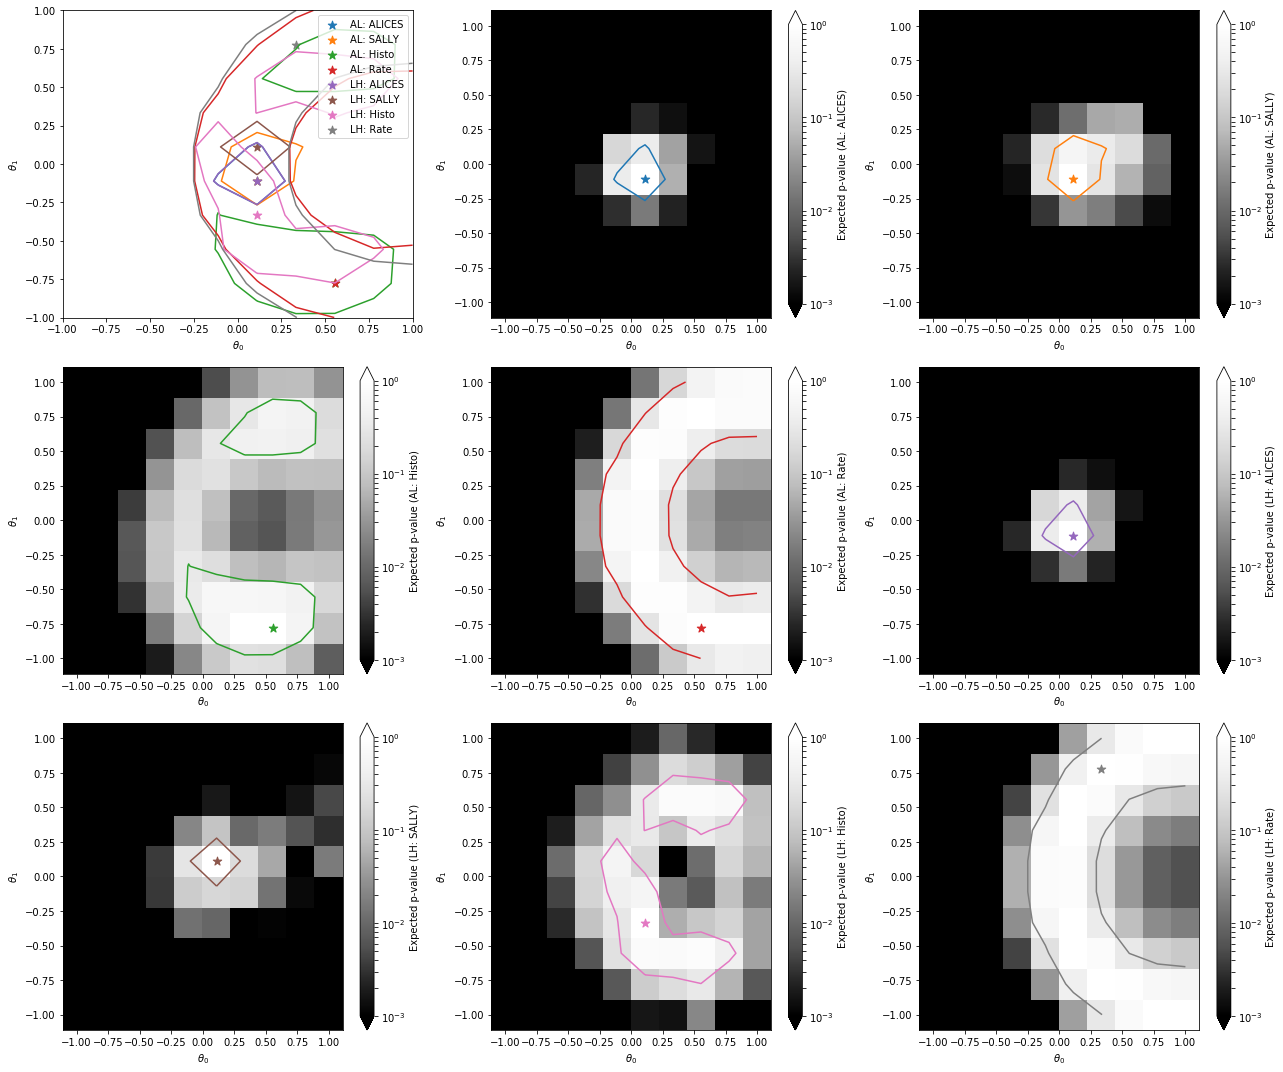

In [15]:
plot_pvalue_limits(
    p_values=p_values,
    best_fits=mle,
    labels=["AL: ALICES", "AL: SALLY", "AL: Histo", "AL: Rate", "LH: ALICES", "LH: SALLY", "LH: Histo", "LH: Rate"],
    grid_ranges=grid_ranges,
    grid_resolutions=grid_resolutions,
    single_plot=False,
#    show_index=1, 
)

We can also look at the computation time:

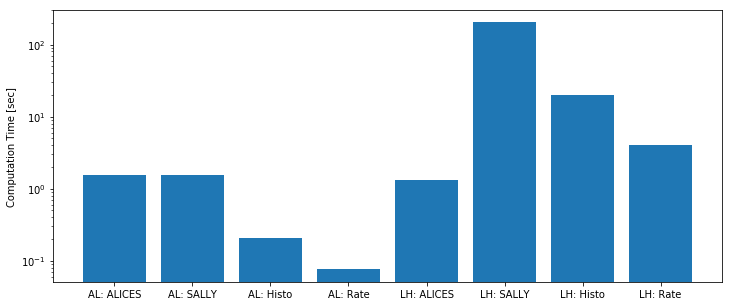

In [16]:
labels = ["AL: ALICES", "AL: SALLY", "AL: Histo", "AL: Rate", "LH: ALICES", "LH: SALLY", "LH: Histo", "LH: Rate"]
times = [durations[str(label)] for label in labels]
indices = [i for i in range(len(labels))]

fig, ax = plt.subplots(figsize=(1.5*len(labels),5))
plt.bar(indices, times)
plt.xticks(indices, labels)
plt.yscale("log")
plt.ylabel("Computation Time [sec]")
plt.show()

## 4 Profile over one parameter

Let's look more closely rate. At first we calculate the expected p-value in a grid.

In [17]:
grid_ranges_rate = [(-1, 3.), (-1, 1.)]
grid_resolutions_rate = [20, 10]
theta_grid_rate, p_values_expected_rate, mle_rate , _ = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=grid_ranges_rate,
    grid_resolutions=grid_resolutions_rate,
)

We can also profile over a parameter using the function `profile_log_likelihood` to profile over the rate only likelihood function.

In [18]:
theta_grid_proj, p_values_expected_proj, best_fit_expected_proj, llr_proj = project_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=[(-1,3)],
    grid_resolutions=[50],
    remaining_components=[0],
)
theta_grid_prof, p_values_expected_prof, best_fit_expected_prof, llr_prof = profile_log_likelihood(
    negative_log_likelihood=nll_rate,
    grid_ranges=[(-1,3)],
    grid_resolutions=[50],
    remaining_components=[0],
    theta_start=np.array([0,0])
)

20:59 madminer.likelihood  INFO    Processed 1.0 % of parameter points in 4.6 seconds.
20:59 madminer.likelihood  INFO    Processed 2.0 % of parameter points in 6.0 seconds.
20:59 madminer.likelihood  INFO    Processed 4.0 % of parameter points in 11.1 seconds.
20:59 madminer.likelihood  INFO    Processed 6.0 % of parameter points in 19.1 seconds.
20:59 madminer.likelihood  INFO    Processed 8.0 % of parameter points in 22.3 seconds.
20:59 madminer.likelihood  INFO    Processed 20.0 % of parameter points in 47.7 seconds.
21:00 madminer.likelihood  INFO    Processed 30.0 % of parameter points in 71.8 seconds.
21:00 madminer.likelihood  INFO    Processed 40.0 % of parameter points in 93.2 seconds.
21:01 madminer.likelihood  INFO    Processed 50.0 % of parameter points in 114.4 seconds.
21:01 madminer.likelihood  INFO    Processed 60.0 % of parameter points in 140.4 seconds.
21:01 madminer.likelihood  INFO    Processed 70.0 % of parameter points in 168.3 seconds.
21:02 madminer.likelihood

Let's now plot both the 2-dimensional and 1-dimensional result.

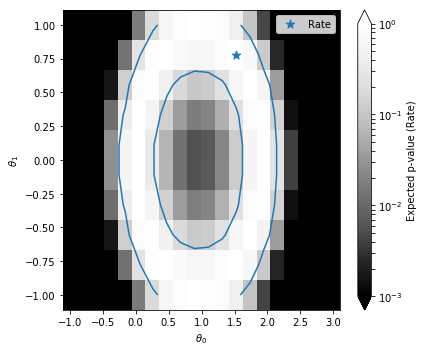

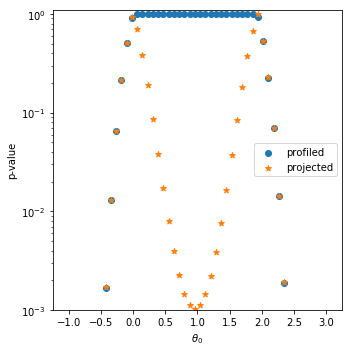

In [21]:
plot_pvalue_limits(
    p_values=np.array([p_values_expected_rate]),
    best_fits=np.array([mle_rate]),
    labels=["Rate"],
    grid_ranges=grid_ranges_rate,
    grid_resolutions=grid_resolutions_rate,
    show_index=0,
)

fig = plt.figure(figsize=(5,5))
plt.scatter(theta_grid_prof,p_values_expected_prof,label="profiled")
plt.scatter(theta_grid_proj,p_values_expected_proj,label="projected",marker="*")
plt.xlabel(r"$\theta_0$")
plt.ylabel("p-value")
plt.yscale("log")
plt.ylim(0.001,1.1)
plt.legend()
plt.tight_layout()
plt.show()

We can see that 2-dimensional has the shape of a donut - it has a blind direction where the rate is unchanged. If we project the likelihood in one dimension (so set the other parameter to zero) we obtain a double peak structue. However, if we properly profile of the other component, we get a plateau. This reflects that in the platau region we can find a value of $\theta$ that leads to the same rate and hence same likelihood as the SM reference point. 